In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pymorphy3

from nltk.corpus import stopwords
from tqdm.auto import tqdm
from wordcloud import WordCloud
from collections import Counter

/home/alex/.cache/pypoetry/virtualenvs/aviation-topic-pipeline-XD-grrq7-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
aeroflot = pd.read_csv('../data/raw/aeroflot_official_posts.csv')
aviatorshina = pd.read_csv('../data/raw/aviatorshina_posts.csv')
favt = pd.read_csv('../data/raw/favt_ru_posts.csv')
s7 = pd.read_csv('../data/raw/s7newsroom_posts.csv')

**Объединие данных из каналов в один датафрейм**

In [64]:
df = pd.concat([aeroflot, aviatorshina, favt, s7], axis=0)
df.head()

,message
0,❄️ Только представьте: полёт в сопровождении о...
1,✈️✈️✈️✈️✈️✈️✈️✈️\n🎁 Пока вы составляете список...
2,В законодательстве РФ изменились правила выезд...
3,🛜 Прокачали навыки нашего чат-бота и подарили ...
4,Связали две столицы с помощью нейросети Аэрофл...


In [65]:
len(df)

7494

**Удаление пустых значений**

In [66]:
df.isnull().sum()

message    3823
dtype: int64

In [67]:
df = df.dropna()

In [68]:
len(df)

3671

**Обработка дубликатов**

In [69]:
np.sum(df.duplicated())

np.int64(2)

In [70]:
df[df.duplicated]

,message
1852,Актуальные новости мира БАС: В Беларуси физлиц...
1593,#Мнение_экспертов — старшего научного сотрудни...


In [71]:
df = df.drop_duplicates(keep='first')

In [72]:
len(df)

3669

**Анализ длин постов**

In [73]:
df['message_lenght'] = df['message'].apply(lambda x: len(x))
df['word_count'] = df['message'].str.split().str.len()

Text(0.5, 0, 'messages_lenght')

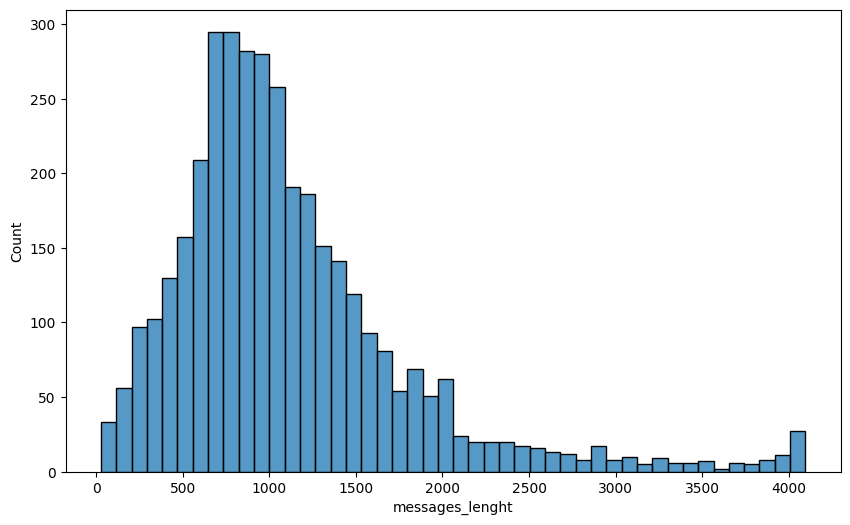

In [74]:
plt.figure(figsize=(10, 6))
sns.histplot(x=df['message_lenght'])
plt.xlabel("messages_lenght")

Text(0.5, 0, 'Count of words')

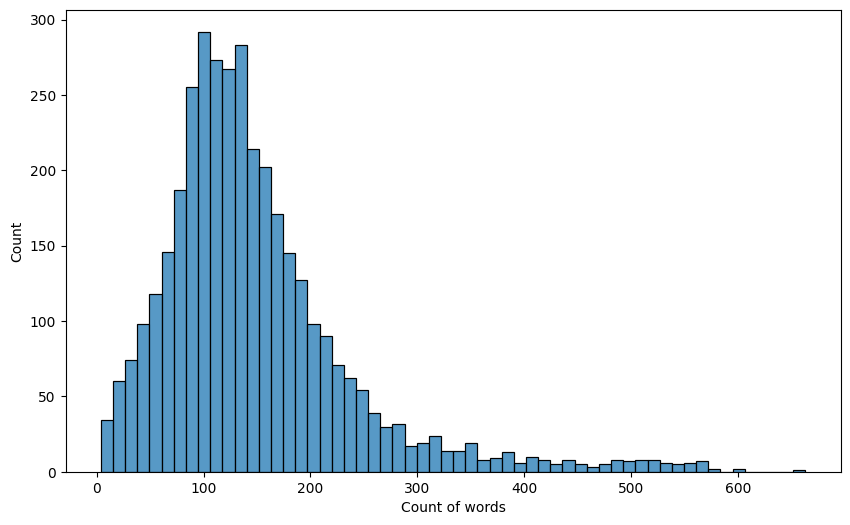

In [75]:
plt.figure(figsize=(10, 6))
sns.histplot(x=df['word_count'])
plt.xlabel("Count of words")

**Удалим слишком короткие и слишком длинные сообщения**

In [76]:
filtered_df = df[df['word_count'] <= 400].copy()

filtered_df = filtered_df[
    (filtered_df['message_lenght']) >= 20 & 
    (filtered_df['message_lenght'] <= 2000)
]
    
print(f"После фильтрации: {len(filtered_df)} сообщений")
print(f"Удалено: {len(df) - len(filtered_df)} сообщений")

После фильтрации: 3564 сообщений
Удалено: 105 сообщений


**Предобработка текстов**

In [77]:
# создаём морфологический анализатор
morph = pymorphy3.MorphAnalyzer()

if 'russian_stopwords' not in locals():
      russian_stopwords = stopwords.words("russian")

texts_as_lists = []

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower() # Приведение к нижнему регистру
        text = text.lower()
        text = re.sub(r'[^а-яё]', ' ', text) # Удаление пунктуации, кроме пробелов
        # разбиваем на слова
        words = text.split()
        # приводим к леммам, убираем стоп-слова и короткие слова (это важно для тематическго моделирования)
        lemmas = [morph.parse(word)[0].normal_form for word in words if word not in russian_stopwords and len(word) > 2]
        texts_as_lists.append(lemmas)
        return " ".join(lemmas)
    return "" # Возвращаем пустую строку для нестроковых значений


print("\nНачало предобработки текста...")
# Применение предобработки к столбцу с текстом. Используем tqdm для отслеживания прогресса.
if 'message' in filtered_df.columns:
    tqdm.pandas()
    filtered_df['processed_text'] = filtered_df['message'].progress_apply(preprocess_text)
    print("Предобработка текста завершена.")
    display(filtered_df.head())


Начало предобработки текста...


100%|██████████| 3564/3564 [00:17<00:00, 198.80it/s]

Предобработка текста завершена.


,message,message_lenght,word_count,processed_text
0,❄️ Только представьте: полёт в сопровождении о...,603,83,представить полёт сопровождение оркестр борт р...
1,✈️✈️✈️✈️✈️✈️✈️✈️\n🎁 Пока вы составляете список...,943,186,пока составлять список подарок новогодний праз...
2,В законодательстве РФ изменились правила выезд...,943,134,законодательство измениться правило выезд неко...
3,🛜 Прокачали навыки нашего чат-бота и подарили ...,727,103,прокачать навык наш чат бот подарить новый суп...
4,Связали две столицы с помощью нейросети Аэрофл...,860,131,связать два столица помощь нейросеть аэрофлот ...


**Облако слов**

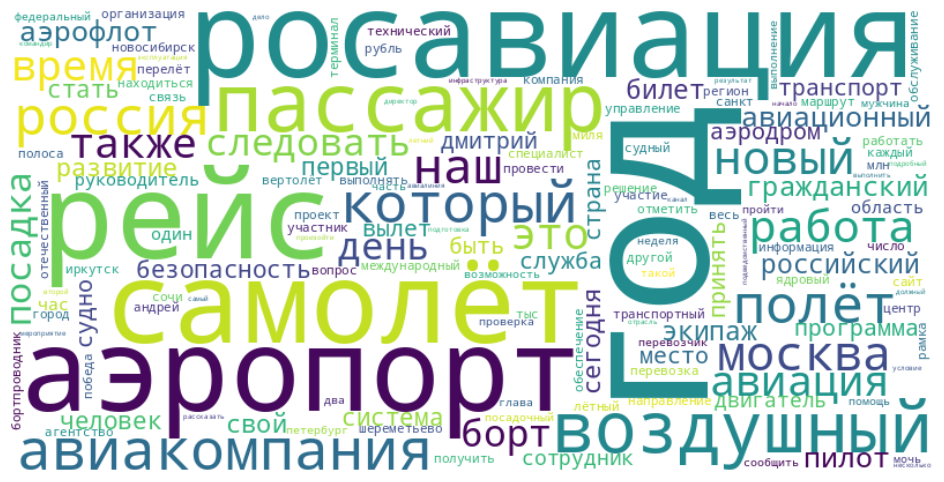

In [ ]:
def create_wordcloud(texts, max_words=100):
    # Объединяем все тексты
    all_text = ' '.join(texts)
    
    # Создаем облако слов
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        collocations=False
    ).generate(all_text)
    
    # Отображаем
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    return wordcloud


wordcloud = create_wordcloud(filtered_df['processed_text'], max_words=150)

In [83]:
filtered_df['processed_text'].to_csv('../data/processed/cleaned_posts_v1.csv', index=False)